In [1]:
!jupyter nbconvert --to script word2vec_actual.ipynb

[NbConvertApp] Converting notebook word2vec_actual.ipynb to script
[NbConvertApp] Writing 6709 bytes to word2vec_actual.py


In [15]:
import pandas as pd
import numpy as np
import re

In [16]:
import os
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

import tqdm

In [17]:
df = pd.read_csv('../data/hate/train.csv')
val_hate = pd.read_csv('../data/hate/val.csv')

In [19]:
df['Sentence'] = df['Sentence'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', str(x)))

In [31]:
df['Sentence']

0       hariyana mey ek week mey teen bachchiyo ke saa...
1       indira gandhi ko marne wala sikhrajiv gandhi k...
2       ishliye corruption ke jariye sab ki khoon choo...
3       pakistaniyon ko aisi news maamul sa ho gaya ha...
4       apne national anthem ko change karo and yeh li...
                              ...                        
3655    sale kardi pakistan wali wo bhi unke talwe cha...
3656    pti walayuchal rahay hain aik tweet prr dusri ...
3657    jaa kay apny behan ky izaat bacha koi rape kaa...
3658    oh godi told u nafirst day jab adi ki ek v sce...
3659    shilpa ki maa bannay ki overacting maa ban ban...
Name: Sentence, Length: 3660, dtype: object

# `Creating Vocabulary`

In [32]:
vocab = []

for sentence in df['Sentence']:
    words = sentence.split()
    vocab.extend(words)
    
wordCount = Counter(vocab)
vocab = {word: i for i, (word, _) in enumerate(wordCount.items())}
inv_vocab = {i: word for word, i in vocab.items()}  # Reverse mapping
vocab_size = len(vocab)

print("Vocabulary size:", vocab_size)

Vocabulary size: 12933


In [33]:
train_sentences = []

for sentence in df['Sentence']:
    train_sentences.extend(sentence.split())

len(train_sentences)

71895

In [34]:
train_sentences = train_sentences

In [35]:
WINDOW_SIZE = 3
NUM_NEGATIVE_SAMPLES = 3

data = []

# Iterate over all words with tqdm progress bar
for idx, center_word in tqdm.tqdm(enumerate(train_sentences[WINDOW_SIZE-1:-WINDOW_SIZE]), 
                             total=len(train_sentences) - 2 * (WINDOW_SIZE - 1), 
                             desc="Processing Pairs"):

    # Get context words around the center word
    context_words = [context_word for context_word in train_sentences[idx:idx+2*WINDOW_SIZE-1] if context_word != center_word]
    
    for context_word in context_words:
        data.append([center_word, context_word, 1])  # Positive pair
        
        # Get negative samples (words NOT in current context)
        negative_samples = np.random.choice(
            [w for w in train_sentences[WINDOW_SIZE-1:-WINDOW_SIZE] if w != center_word and w not in context_words], 
            NUM_NEGATIVE_SAMPLES, 
            replace=False
        )

        for negative_samp in negative_samples:
            data.append([center_word, negative_samp, 0])  # Negative pair

Processing Pairs:   0%|          | 85/71891 [00:06<1:32:59, 12.87it/s]


KeyboardInterrupt: 

In [10]:
df = pd.DataFrame(columns=['center_word', 'context_word', 'label'], data=data)
words = np.intersect1d(df.context_word, df.center_word)
df = df[(df.center_word.isin(words)) & (df.context_word.isin(words))].reset_index(drop=True)
df

,center_word,context_word,label
0,ek,fir,0
1,ek,filmo,0
2,ek,re,0
3,ek,mey,1
4,ek,hogya,0
...,...,...,...
95634,ne,kiss,0
95635,ne,ka,1
95636,ne,city,0
95637,ne,Maine,0


In [20]:
len(vocab)

17305

In [11]:
import pandas as pd

# Create a new DataFrame (deep copy to avoid modifying the original)
df_ids = df.copy()

# Replace words with their corresponding IDs from vocab
df_ids['center_word'] = df_ids['center_word'].map(lambda w: vocab.get(w, -1))
df_ids['context_word'] = df_ids['context_word'].map(lambda w: vocab.get(w, -1))



In [12]:
# Print the first few rows to verify
df_ids.head()


,center_word,context_word,label
0,2,306,0
1,2,2477,0
2,2,2659,0
3,2,1,1
4,2,453,0


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)  # Word embedding matrix
        self.output_embeddings = nn.Embedding(vocab_size, embed_dim)  # Context embedding matrix
    
    def forward(self, target, context):
        target_emb = self.embeddings(target)  # (batch_size, embed_dim)
        context_emb = self.output_embeddings(context)  # (batch_size, embed_dim)
        scores = torch.sum(target_emb * context_emb, dim=1)  # Dot product similarity
        return scores

# Model parameters
embed_dim = 100  # Word embedding size
model = Word2Vec(vocab_size, embed_dim)


In [14]:
X = df_ids[['center_word', 'context_word']].values  # Word ID pairs as input
y = df_ids['label'].values  # Labels (0 or 1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model Configuration
VOCAB_SIZE = len(vocab) + 1  # Add 1 for unknown words
EMBEDDING_DIM = 100  # As required
HIDDEN_DIM = 64  # Hidden layer size
BATCH_SIZE = 128  # Adjustable
EPOCHS = 50  # Number of training epochs
LR = 0.001  # Learning rate

# Define Word2Vec Model with Binary Classification
class Word2VecClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Word2VecClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Word embedding layer
        self.fc1 = nn.Linear(embedding_dim * 2, hidden_dim)  # Hidden layer
        self.fc2 = nn.Linear(hidden_dim, 1)  # Output layer (binary classification)
        self.sigmoid = nn.Sigmoid()  # Binary classification activation

    def forward(self, x):
        word1 = self.embedding(x[:, 0])  # Get embedding for center_word
        word2 = self.embedding(x[:, 1])  # Get embedding for context_word
        combined = torch.cat((word1, word2), dim=1)  # Concatenate embeddings
        hidden = torch.relu(self.fc1(combined))  # Hidden layer with ReLU
        output = self.sigmoid(self.fc2(hidden))  # Binary classification output
        return output

# Initialize Model and Move to GPU
model = Word2VecClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM).to(device)


Using device: cuda


In [16]:
# Convert DataFrame to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.long).to(device)  # Word indices must be long
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)  # Labels must be float

# Create Dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [17]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should print True if GPU is available


2.6.0+cu124
True


In [18]:
# Loss function and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm.tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)  # tqdm progress bar
    
    for batch in loop:
        x_batch, y_batch = batch  # Unpack batch
        optimizer.zero_grad()  # Reset gradients
        outputs = model(x_batch).squeeze()  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        total_loss += loss.item()

        # Update tqdm bar with loss
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}/{EPOCHS}, Avg Loss: {total_loss / len(dataloader)}")



Epoch 1/5: 100%|██████████| 748/748 [00:05<00:00, 145.07it/s, loss=0.682]


Epoch 1/5, Avg Loss: 0.5749512828368554


Epoch 2/5: 100%|██████████| 748/748 [00:04<00:00, 171.38it/s, loss=0.755]


Epoch 2/5, Avg Loss: 0.5621396576497644


Epoch 3/5: 100%|██████████| 748/748 [00:04<00:00, 167.99it/s, loss=0.6]  


Epoch 3/5, Avg Loss: 0.5572760949000956


Epoch 4/5: 100%|██████████| 748/748 [00:04<00:00, 173.63it/s, loss=0.549]


Epoch 4/5, Avg Loss: 0.5510645405972068


Epoch 5/5: 100%|██████████| 748/748 [00:04<00:00, 151.25it/s, loss=0.511]

Epoch 5/5, Avg Loss: 0.537929312311073


In [ ]:
torch.save(model.state_dict(), "models/2/word2vec_classifier_50epoch.pth")
print("Model saved successfully!")


Model saved successfully!


In [2]:
import os
import pandas as pd
import numpy as np
import tqdm
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
from collections import Counter

# ===============================
# 1️⃣ Load Dataset & Create Vocabulary
# ===============================

df = pd.read_csv('../data/hate/train.csv')

# Create Vocabulary
vocab = Counter(word for sentence in df['Sentence'] for word in sentence.split())
word2idx = {word: i for i, (word, _) in enumerate(vocab.items())}
idx2word = {i: word for word, i in word2idx.items()}
vocab_size = len(word2idx)
print("Vocabulary size:", vocab_size)

# # Convert Sentences to Word Indices
# train_sentences = [word2idx[word] for sentence in df['Sentence'] for word in sentence.split()]
# train_sentences = np.array(train_sentences, dtype=np.int32)

# # ===============================
# # 2️⃣ Optimized Training Pair Generation
# # ===============================

# WINDOW_SIZE = 3
# NUM_NEGATIVE_SAMPLES = 3
# NEGATIVE_SAMPLING_TABLE_SIZE = 1_000_000  # Large table for efficient sampling

# # **🔹 Precompute a large table for negative sampling**
# word_freqs = np.array(list(vocab.values()), dtype=np.float32)
# word_freqs = word_freqs ** 0.75  # Smooth frequency
# word_freqs /= word_freqs.sum()  # Normalize
# negative_sample_table = np.random.choice(
#     list(word2idx.values()), size=NEGATIVE_SAMPLING_TABLE_SIZE, p=word_freqs
# )

# # **🔹 Generate Training Pairs Efficiently**
# data = []
# neg_idx = 0

# for i in tqdm.tqdm(range(WINDOW_SIZE, len(train_sentences) - WINDOW_SIZE), desc="Generating Pairs"):
#     center_word = train_sentences[i]
#     context_words = np.concatenate((train_sentences[i - WINDOW_SIZE:i], train_sentences[i + 1:i + 1 + WINDOW_SIZE]))

#     for context_word in context_words:
#         data.append([center_word, context_word, 1])  # Positive sample

#         # **Fast Negative Sampling**
#         neg_samples = []
#         while len(neg_samples) < NUM_NEGATIVE_SAMPLES:
#             neg_word = negative_sample_table[neg_idx]
#             neg_idx = (neg_idx + 1) % NEGATIVE_SAMPLING_TABLE_SIZE  # Circular index
#             if neg_word not in context_words and neg_word != center_word:
#                 neg_samples.append(neg_word)

#         for neg_word in neg_samples:
#             data.append([center_word, neg_word, 0])  # Negative sample

# # Convert to DataFrame
# df_pairs = pd.DataFrame(data, columns=['center_word', 'context_word', 'label'])
# df_pairs = df_pairs.drop_duplicates().reset_index(drop=True)

# print(f"Total training pairs: {len(df_pairs)}")



Vocabulary size: 17305


In [1]:
import torch 
import torch.nn as nn
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.output_embeddings = nn.Embedding(vocab_size, embed_dim)
    
    def forward(self, target, context):
        target_emb = self.embeddings(target)  # (batch_size, embed_dim)
        context_emb = self.output_embeddings(context)  # (batch_size, embed_dim)
        scores = torch.sum(target_emb * context_emb, dim=1)  # Dot product similarity
        return scores

# ===============================
# 5️⃣ Training Loop
# ===============================

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model Configuration
EMBEDDING_DIM = 100
EPOCHS = 10
LR = 0.001

# Initialize Model
model = Word2Vec(vocab_size, EMBEDDING_DIM)

Using device: cuda


NameError: name 'vocab_size' is not defined

In [61]:
import numpy as np

# Extract word embeddings
word_embeddings = model.embeddings.weight.data.cpu().numpy()  # Move to CPU if on GPU

# Save embeddings with word mappings
embedding_dict = {idx2word[i]: word_embeddings[i] for i in range(vocab_size)}

# Save as a NumPy file
np.save("models/word2vec/word_embeddings.npy", embedding_dict)

print("✅ Word embeddings saved successfully!")


FileNotFoundError: [Errno 2] No such file or directory: 'models/word2vec/word_embeddings.npy'

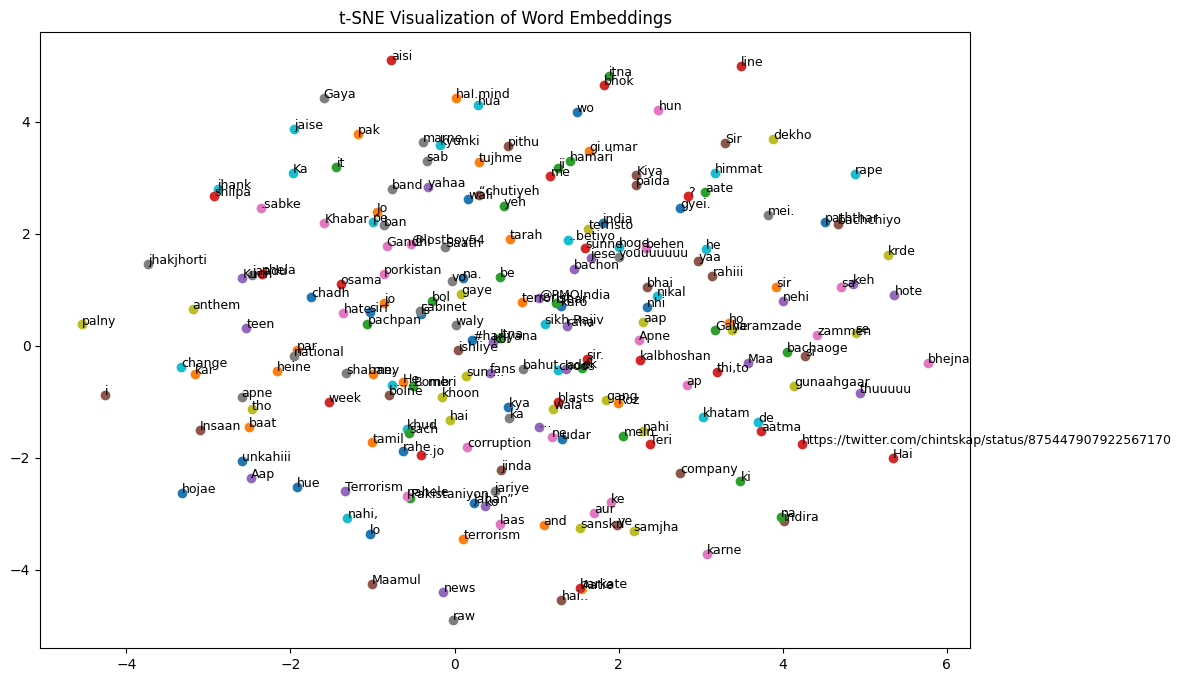

In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load saved embeddings
embedding_dict = np.load("models/word2vec/word_embeddings.npy", allow_pickle=True).item()

# Select 200 most frequent words for visualization
top_words = list(embedding_dict.keys())[:200]
top_embeddings = np.array([embedding_dict[word] for word in top_words])

# Reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(top_embeddings)

# Plot embeddings
plt.figure(figsize=(12, 8))
for i, word in enumerate(top_words):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()


In [94]:
top_words[0], top_embeddings[0].shape

('#hariyana', (100,))

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_words(target_word, top_n=5):
    if target_word not in embedding_dict:
        print("Word not in vocabulary!")
        return

    target_embedding = embedding_dict[target_word].reshape(1, -1)
    all_words = list(embedding_dict.keys())
    all_embeddings = np.array([embedding_dict[word] for word in all_words])

    # Compute cosine similarity
    similarities = cosine_similarity(target_embedding, all_embeddings)[0]
    top_indices = similarities.argsort()[-top_n-1:-1][::-1]

    # Display similar words
    print(f"Words similar to '{target_word}':")
    for idx in top_indices:
        print(f"{all_words[idx]} (Similarity: {similarities[idx]:.4f})")

# Example usage
find_similar_words("terrorist")


Words similar to 'terrorist':
@DrRutvij (Similarity: 0.4775)
sadi (Similarity: 0.3631)
karwayengi??? (Similarity: 0.3607)
jayaigi (Similarity: 0.3545)
inlogo (Similarity: 0.3434)


In [62]:
import numpy as np
import torch

# Load embeddings
embedding_dict = np.load("models/word2vec_10epocj/word_embeddings.npy", allow_pickle=True).item()

# Convert to tensor
vocab_size = len(embedding_dict)
embedding_dim = len(next(iter(embedding_dict.values())))  # Get embedding size

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word2idx = {word: idx for idx, word in enumerate(embedding_dict.keys())}

for word, idx in word2idx.items():
    embedding_matrix[idx] = embedding_dict[word]

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


In [95]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Load dataset
df = pd.read_csv("../data/hate/train.csv")

# Convert text to sequences of word indices
def text_to_sequence(text):
    return [word2idx[word] for word in text.split() if word in word2idx]

df["sequence"] = df["Sentence"].apply(text_to_sequence)

# Padding sequences to the same length
MAX_LEN = 100  # Choose max sentence length
def pad_sequence(seq, max_len=MAX_LEN):
    return seq[:max_len] + [0] * (max_len - len(seq))  # Pad with zeros if shorter

df["padded_seq"] = df["sequence"].apply(lambda x: pad_sequence(x))

# Convert labels to numerical valuesZ
label_mapping = {"hate": 0, "non-hate": 1,}  # Adjust if needed
df["label"] = df["Tag"].astype(int)

In [96]:
df["label"]

0       1
1       1
2       1
3       0
4       1
       ..
3655    1
3656    0
3657    0
3658    1
3659    1
Name: label, Length: 3660, dtype: int64

In [97]:
class HateSpeechDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create dataset
dataset = HateSpeechDataset(df["padded_seq"].tolist(), df["label"].tolist())

# DataLoader
BATCH_SIZE = 32
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [98]:
i, l = next(iter(dataloader))

In [99]:
i.shape, l.shape

(torch.Size([32, 100]), torch.Size([32]))

In [100]:
import torch.nn as nn
import torch.nn.functional as F

class FFNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(FFNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, max_len, embed_dim)
        x = torch.mean(x, dim=1)  # Average word embeddings (batch_size, embed_dim)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # No softmax, as we'll use CrossEntropyLoss


In [101]:
!export CUDA_LAUNCH_BLOCKING=1

In [102]:
!export CUDA_LAUNCH_BLOCKING=1
import torch.optim as optim

# Set device
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# Initialize model
model = FFNNClassifier(vocab_size, embedding_dim, hidden_dim=64, num_classes=2).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
from tqdm import tqdm

EPOCHS = 10
for epoch in range(EPOCHS):
    total_loss = 0
    model.train()
    
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for sequences, labels in loop:
        sequences, labels = sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        print(labels.min().item(), labels.max().item())  # Should be between 0 and 2 (if num_classes=3)

        optimizer.step()
        
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())  # Show loss in tqdm

    print(f"Epoch {epoch+1}/{EPOCHS}, Avg Loss: {total_loss / len(dataloader):.4f}")


Epoch 1/10:   0%|          | 0/115 [00:00<?, ?it/s]

0 1


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
